Generating Data

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pylab


mean0 = -np.ones(2)
mean1 = np.ones(2)
cov = np.eye(2)
n_s = 100     #ns : sample size
group0 = np.random.multivariate_normal(mean0, cov, n_s)
group1 = np.random.multivariate_normal(mean1, cov, n_s)


data = np.empty((2*n_s,3))
data[0:n_s,[0,1]] = group0
data[n_s:2*n_s,[0,1]] = group1
data[0:n_s,[2]] = 0
data[n_s:2*n_s,[2]] = 1

np.random.shuffle(data)

M = 150
train_data = data[0:M, :]
test_data = data[M: , :]

Defining all the needed functions in the "Second_Order" class 

In [24]:
import torch

class Second_Order:
  def __init__(self, train_data, test_data, coef):
    self.train_data = train_data
    self.test_data = test_data
    self.coef = coef
    self.X = torch.tensor(data[0:M,[0,1]])
    self.y = torch.tensor(data[0:M,[2]]).reshape((M,1))
    
  def loss(self, w):
    w = w.reshape((2,1))
    z = self.coef * torch.matmul(self.X, w)
    y_hat = 1/(1+torch.exp(-z)).reshape(M,1) 
    return -1/M*(torch.matmul(self.y.T, torch.log(y_hat)) + torch.matmul((1-self.y).T, torch.log(1-y_hat)))

  def accuracy(self, w):
    X_test = torch.tensor(test_data[:,:2])
    y_test = torch.tensor(test_data[:,[2]]).reshape(50,1)
    w = w.reshape((2,1))
    z = self.coef * torch.matmul(X_test,w)
    y_hat = 1/(1+np.exp(-z)).reshape(50,1)
    #print(y_hat)
    #print(y_test)
    #print((y_hat>0.5).astype(int).T)
    #print((y_test>0.5).astype(int).T)
    corrects = torch.matmul((y_hat>0.5).int().T, (y_test>0.5).int()) +  torch.matmul(((y_hat<0.5).int()).T, (y_test<0.5).int())
    return corrects.item()/50

  def plot_level_sets(self):
    eps = 0.1
    w1Points = np.arange(-2+eps,2,eps)
    w2Points = np.arange(-2+eps,2,eps)
    n = (int)(4/eps - 1)
    val = np.empty((n,n))

    for i in range(n):
      for j in range(n):
        w = torch.tensor([w1Points[i], w2Points[j]])
        val[i][j] = self.loss(w).item()


    plt.title('Contour plot')
    plt.xlabel('w1')
    plt.ylabel('w2')
    contours = plt.contour(w1Points, w2Points, val)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.show()

  def GD(self, learning_rate, n_iters):
    w = torch.tensor([0,0], dtype=torch.double, requires_grad=True)
    loss_list =[]
    for step in range(n_iters):
        l = self.loss(w)
        l.backward()
        with torch.no_grad():
            w -= learning_rate * w.grad

        loss_list.append(self.loss(w))

        w.grad.zero_()

        if step % 1 == 0:
            print('step ', step+1 , '  w=', w.detach().numpy() , '  loss=' , l.item() , '  accuracy=', self.accuracy(w.detach()))

    return loss_list

  def Newton(self, learning_rate, n_iters):
    w = torch.tensor([0,0], dtype=torch.double, requires_grad=True)
    loss_list =[]

    for step in range(n_iters):
      l = self.loss(w)
      l.backward()
      
      grad = w.grad
      hessian = torch.autograd.functional.hessian(self.loss, w)
      #print(hessian)
      delta_w = - torch.matmul(torch.inverse(hessian), grad)

      with torch.no_grad():  
        w += learning_rate * delta_w
      
      loss_list.append(self.loss(w))
      
      w.grad.zero_()

      if step % 1 == 0:
          print('step ', step+1 , '  w=', w.detach().numpy() , '  loss=' , l.item() , '  accuracy=', self.accuracy(w.detach()))
    return loss_list

  def NG(self, learning_rate, n_iters):
    w = torch.tensor([0,0], dtype=torch.double, requires_grad=True)
    loss_list = []
    y_hat_list = torch.zeros(n_iters,50).detach().clone()

    for step in range(n_iters):
      #Computing Emperical Fisher Information Matrix

      F = torch.zeros(2,2).double().clone().detach()

      for i in range(M):
        z = self.coef * torch.matmul(self.X[i,:], w)
        y_hat = 1/(1+torch.exp(-z))
        l = self.y[i].item() * torch.log(y_hat) + (1-self.y[i].item())* torch.log(1-y_hat)
        
        l.backward()
        with torch.no_grad():
          grad = w.grad.reshape((2,1))
          F += torch.matmul(grad, grad.T)
        
        w.grad.zero_()
        
      F /= M
        
      l = self.loss(w)
      l.backward()

      with torch.no_grad():
        w -= learning_rate * torch.matmul(torch.inverse(F), w.grad)
        
      loss_list.append(self.loss(w))
      z = torch.matmul(torch.tensor(self.test_data[:,[0,1]]), w)
      y_hat = 1/(1+torch.exp(-z)).reshape(50)
      y_hat_list[step,:] = y_hat

      w.grad.zero_()

      if step % 1 == 0:
        print('step ', step+1 , '  w=', w.detach().numpy() , '  loss=' , l.item() , '  accuracy=', self.accuracy(w.detach()))     

    return loss_list, y_hat_list


Part 2: Level Plots

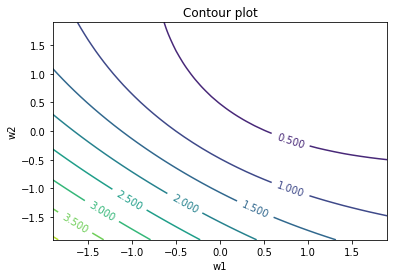

In [25]:
obj = Second_Order(train_data, test_data, 1)
obj.plot_level_sets()

Part 3: Gradient Descent 

In [26]:
obj = Second_Order(train_data, test_data, 1)
loss3 = obj.GD(0.2, 5)

step  1   w= [0.10428678 0.09868224]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [0.1926987  0.18184642]   loss= 0.5980884411241449   accuracy= 0.94
step  3   w= [0.26838982 0.25263798]   loss= 0.5298752896161192   accuracy= 0.94
step  4   w= [0.33407288 0.31376525]   loss= 0.47983217853015864   accuracy= 0.94
step  5   w= [0.39184996 0.36732109]   loss= 0.44207305248577394   accuracy= 0.94


Part 4: Newton

In [27]:
obj = Second_Order(train_data, test_data, 1)
loss4 = obj.Newton(1, 5)

step  1   w= [0.70449574 0.59323765]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [1.13248614 1.04851733]   loss= 0.3116438439230872   accuracy= 0.94
step  3   w= [1.4884416  1.50068866]   loss= 0.23616631989888667   accuracy= 0.94
step  4   w= [1.73173759 1.82206308]   loss= 0.21218714021180848   accuracy= 0.94
step  5   w= [1.81672379 1.9327521 ]   loss= 0.20722437788204592   accuracy= 0.94


Part 6: Natural Gradient

In [28]:
obj = Second_Order(train_data, test_data, 1)
loss6, y_hat6 = obj.NG(0.2, 5)

step  1   w= [0.14089915 0.11864753]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [0.3144296  0.27812186]   loss= 0.574219682812677   accuracy= 0.94
step  3   w= [0.53684806 0.51547995]   loss= 0.4577519813943829   accuracy= 0.94
step  4   w= [0.81441626 0.87961644]   loss= 0.35063429455760925   accuracy= 0.94
step  5   w= [1.07781915 1.29091937]   loss= 0.2690082070169916   accuracy= 0.96


Part 7: Level Plots

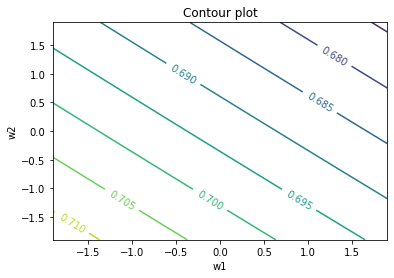

In [29]:
obj = Second_Order(train_data, test_data, 0.01)
obj.plot_level_sets()

Part 8: Gradient Descent

step  1   w= [0.00104287 0.00098682]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [0.00208572 0.00197363]   loss= 0.6931368736817481   accuracy= 0.94
step  3   w= [0.00312856 0.00296042]   loss= 0.6931265671257462   accuracy= 0.94
step  4   w= [0.00417137 0.0039472 ]   loss= 0.6931162608919295   accuracy= 0.94
step  5   w= [0.00521418 0.00493396]   loss= 0.6931059549802876   accuracy= 0.94


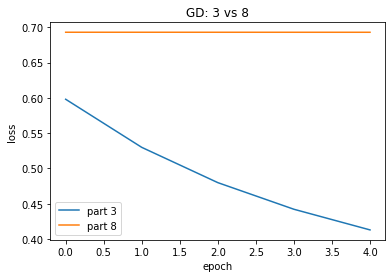

In [30]:
obj = Second_Order(train_data, test_data, 0.01)
loss8 = obj.GD(0.2, 5)


plt.title("GD: 3 vs 8")
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(loss3, label = 'part 3')
plt.plot(loss8 , label = 'part 8')
plt.legend()
plt.show()


Part 9: Newton

step  1   w= [70.44957445 59.32376453]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [113.24861365 104.85173274]   loss= 0.31164384392308714   accuracy= 0.94
step  3   w= [148.84416048 150.06886591]   loss= 0.23616631989888667   accuracy= 0.94
step  4   w= [173.17375896 182.2063081 ]   loss= 0.2121871402118085   accuracy= 0.94
step  5   w= [181.67237915 193.27521003]   loss= 0.20722437788204592   accuracy= 0.94


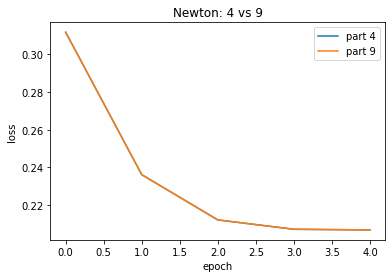

In [31]:
obj = Second_Order(train_data, test_data, 0.01)
loss9 = obj.Newton(1, 5)

plt.title("Newton: 4 vs 9")
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(loss4, label = 'part 4')
plt.plot(loss9 , label = 'part 9')
plt.legend()
plt.show()


Part 10: Natural Gradient

step  1   w= [14.08991489 11.86475291]   loss= 0.6931471805599455   accuracy= 0.94
step  2   w= [31.4429604  27.81218623]   loss= 0.574219682812677   accuracy= 0.94
step  3   w= [53.68480611 51.54799518]   loss= 0.4577519813943829   accuracy= 0.94
step  4   w= [81.44162623 87.96164407]   loss= 0.35063429455760925   accuracy= 0.94
step  5   w= [107.78191476 129.09193688]   loss= 0.2690082070169915   accuracy= 0.96


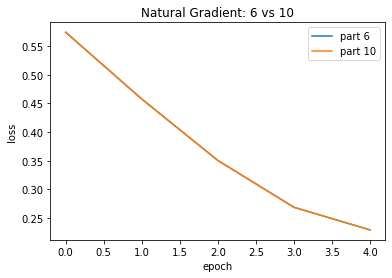

In [32]:
obj = Second_Order(train_data, test_data, 0.01)
loss10 , y_hat10 = obj.NG(0.2, 5)

plt.title("Natural Gradient: 6 vs 10")
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(loss6, label = 'part 6')
plt.plot(loss10 , label = 'part 10')
plt.legend()
plt.show()

Part 12: Natural Gradient Likelihood

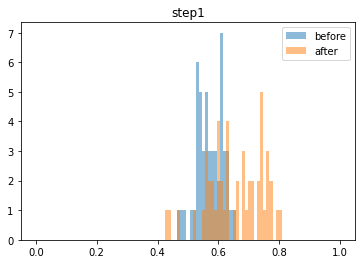

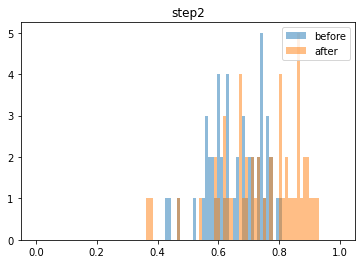

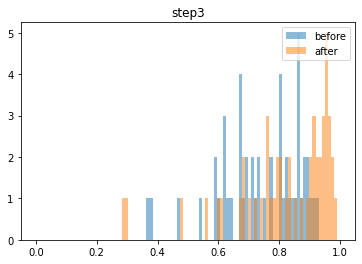

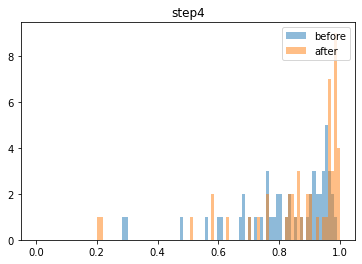

In [33]:

y = test_data[:, 2]
y_hat = y_hat6.detach().numpy()

for i in range(4):
  x1 = []
  x2 = []
  for j in range(50):
    x1.append((y_hat[i][j]**y[j])*((1-y_hat[i][j])**(1-y[j])))
    x2.append((y_hat[i+1][j]**y[j])*((1-y_hat[i+1][j])**(1-y[j])))

  bins = np.linspace(0, 1, 100)

  plt.title('step' + str(i+1))
  plt.hist(x1, bins, alpha=0.5 , label='before')
  plt.hist(x2, bins, alpha=0.5, label='after')
  plt.legend(loc='upper right')
  plt.show()
  plt.show()  